In [1]:
import os
from six.moves import urllib
import zipfile
import pandas as pd

DOWNLOAD_EPA_ROOT = "https://aqs.epa.gov/aqsweb/airdata/annual_aqi_by_county_"
AQI_BASE_NAME = "annual_aqi_by_county_"
EPA_PATH = "epa_data"

def fetch_annual_aqi_data(years, epa_root=DOWNLOAD_EPA_ROOT, data_path=EPA_PATH):
    if not os.path.isdir(data_path):
        os.makedirs(data_path)
        
    data_frames = []
    for year in years:
        # build download url and download zip file
        aqi_url = f"{epa_root}{year}.zip"
        aqi_name = f"{AQI_BASE_NAME}{year}.zip"
        zip_path = os.path.join(data_path, aqi_name)
        urllib.request.urlretrieve(aqi_url, zip_path)
        
        # extract zip file
        zip_ref = zipfile.ZipFile(zip_path, 'r')
        zip_ref.extractall(data_path)
        zip_ref.close()
        
        # delete zipfile
        os.remove(zip_path)
        
        # read csv
        aqi_csv_name = f"{AQI_BASE_NAME}{year}.csv"
        aqi_csv_path = os.path.join(data_path, aqi_csv_name)
        data_frames.append(pd.read_csv(aqi_csv_path))
        
        # remove individual year .csv
        os.remove(aqi_csv_path)
        
    # write out combined data
    all_csv_name = "all_years.csv"
    all_csv_path = os.path.join(data_path, all_csv_name)
    
    all_df = pd.concat(data_frames, ignore_index=True)
    all_df.to_csv(all_csv_path)
    
    return all_df
        

In [2]:
# Pick years 1989, 1993 - 2017 which corresponds to all years in SAIPE data frame
all_years = fetch_annual_aqi_data([2017,2016,2015,2013,2014,2012,2010,2011,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000,1999,1998,1997,1996,1995,1993,1989])

In [3]:
all_years.shape

(26385, 19)

In [4]:
# downloaded SMALL AREA INCOME AND POVERTY ESTIMATE DATA
## This is the reference to the small area census data and the years available
#https://www.census.gov/cgi-bin/nbroker?_service=sas_serv1&_debug=0&_program=cedr.sasapp_main.sas&s_output=csv&s_orderBy=id%20asc,id%20asc,%20year%20desc&s_appName=saipe&menu=grid_proxy&s_year=2017,2016,2015,2013,2014,2012,2010,2011,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000,1999,1998,1997,1996,1995,1993,1989&s_state=&s_county=&s_district=&s_USStOnly=n&s_inclUsTot=n&s_inclStTot=n&s_measures=aa_snc
# saipe_
#small_area_df = pd.read_csv("SAIPESNC_10APR19_19_47_46_33.csv")
# the requested years are in the url

SAIPE_URL = "https://www.census.gov/cgi-bin/nbroker?_service=sas_serv1&_debug=0&_program=cedr.sasapp_main.sas&s_output=csv&s_orderBy=id%20asc,id%20asc,%20year%20desc&s_appName=saipe&menu=grid_proxy&s_year=2017,2016,2015,2013,2014,2012,2010,2011,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000,1999,1998,1997,1996,1995,1993,1989&s_state=&s_county=&s_district=&s_USStOnly=n&s_inclUsTot=n&s_inclStTot=n&s_measures=aa_snc"
SAIPE_PATH = "saipe_data"

def fetch_saipe_data(saipe_url=SAIPE_URL, data_path=SAIPE_PATH):
    if not os.path.isdir(data_path):
        os.makedirs(data_path)

    # download the online file to a local .csv file
    saipe_name = "saipe.csv"
    saipe_path = os.path.join(data_path, saipe_name)
    urllib.request.urlretrieve(saipe_url, saipe_path)
    
fetch_saipe_data()


PermissionError: [Errno 13] Permission denied: 'saipe_data\\saipe.csv'

In [7]:
# I was able to download the file before so go ahead and load

In [5]:
def load_saipe_data(saipe_path=SAIPE_PATH):
    csv_path = os.path.join(saipe_path, "saipe.csv")
    return pd.read_csv(csv_path)

small_area_df = load_saipe_data()

In [6]:
small_area_df.shape

(78543, 44)

In [ ]:
# Checking on methods to clean up state/county names to begin merging dataframes

In [51]:
# Get rid of country of mexico in epa data
all_years_df = all_years[all_years.State != 'Country Of Mexico']


In [41]:
# use a Python dict of us_state_abbrev from github.com/rogerallen

from us_state_abbrev import us_state_abbrev as abbrev_dict

abbrev_dict['Country Of Mexico'] = 'MX'
abbrev_dict['District Of Columbia'] = 'DC'

def combine_state_county (df):
    new_column = []
    for index, row in df.iterrows():
        new_column.append(f"{df.loc[index,'County']} ({abbrev_dict[df.loc[index,'State']]})")
    return new_column

In [44]:
locale_name = combine_state_county(all_years_df) # need to get rid of 'Country of Mexico' and others in the all_years dataframe

In [52]:
all_years_df.insert(0, "Name", locale_name)

In [53]:
all_years_df.head()

,Name,State,County,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days SO2,Days PM2.5,Days PM10
0,Baldwin (AL),Alabama,Baldwin,2017,270,241,28,1,0,0,0,108,51,36,0,0,206,0,64,0
1,Clay (AL),Alabama,Clay,2017,118,104,14,0,0,0,0,66,52,30,0,0,0,0,118,0
2,Colbert (AL),Alabama,Colbert,2017,283,265,18,0,0,0,0,63,48,37,0,0,218,0,65,0
3,DeKalb (AL),Alabama,DeKalb,2017,359,329,30,0,0,0,0,80,50,39,0,0,315,0,44,0
4,Elmore (AL),Alabama,Elmore,2017,226,221,5,0,0,0,0,58,45,35,0,0,226,0,0,0


In [48]:
# remove 'County' 'Parish' from SAIPE state/county id

def remove_county_parish (df):
    new_column = []
    for index, row in df.iterrows():
        new_column.append(df.loc[index,'State / County Name'].replace(' County', '').replace(' Parish', ''))
    return new_column


In [54]:
locale_name = remove_county_parish(small_area_df)

In [55]:
# add the new name back to the small_area_df
small_area_df.insert(0, "Name", locale_name)
small_area_df.head()

,Name,Year,State,County ID,State / County Name,All Ages SAIPE Poverty Universe,All Ages in Poverty Count,All Ages in Poverty Count LB 90%,All Ages in Poverty Count UB 90%,90% Confidence Interval (All Ages in Poverty Count),...,Under Age 5 in Poverty Count UB 90%,90% Confidence Interval (Under Age 5 in Poverty Count),Under Age 5 in Poverty Percent,Under Age 5 in Poverty Percent LB 90%,Under Age 5 in Poverty Percent UB 90%,90% Confidence Interval (Under Age 5 in Poverty Percent),Median Household Income in Dollars,Median Household Income in Dollars LB 90%,Median Household Income in Dollars UB 90%,90% Confidence Interval (Median Household Income in Dollars)
0,Autauga (AL),2017,1,1001,Autauga County (AL),"55,021","7,390","6,147","8,633","6,147 to 8,633",...,NaN,NaN,NaN,NaN,NaN,NaN,"$58,343","$52,121","$64,565","$52,121 to $64,565"
1,Autauga (AL),2016,1,1001,Autauga County (AL),"54,939","7,444","6,255","8,633","6,255 to 8,633",...,NaN,NaN,NaN,NaN,NaN,NaN,"$54,487","$50,886","$58,088","$50,886 to $58,088"
2,Autauga (AL),2015,1,1001,Autauga County (AL),"54,860","6,966","5,673","8,259","5,673 to 8,259",...,NaN,NaN,NaN,NaN,NaN,NaN,"$56,580","$51,459","$61,701","$51,459 to $61,701"
3,Autauga (AL),2014,1,1001,Autauga County (AL),"54,903","7,204","5,845","8,563","5,845 to 8,563",...,NaN,NaN,NaN,NaN,NaN,NaN,"$54,366","$50,916","$57,816","$50,916 to $57,816"
4,Autauga (AL),2013,1,1001,Autauga County (AL),"54,762","7,397","6,109","8,685","6,109 to 8,685",...,NaN,NaN,NaN,NaN,NaN,NaN,"$51,868","$48,314","$55,422","$48,314 to $55,422"


In [57]:
# combining the two dataframes on Name and Year
combined_df = pd.merge(all_years_df, small_area_df, on=["Name", "Year"])

In [64]:
combined_df.drop(columns = ['State_x', 'County', 'State_y', 'County ID', 'State / County Name',\
                           'All Ages in Poverty Count LB 90%','All Ages in Poverty Count UB 90%',\
                            '90% Confidence Interval (All Ages in Poverty Count)',\
                            'All Ages in Poverty Percent LB 90%', 'All Ages in Poverty Percent UB 90%',\
                            '90% Confidence Interval (All Ages in Poverty Percent)',\
                            'Under Age 18 SAIPE Poverty Universe', 'Under Age 18 in Poverty Count',\
                            'Under Age 18 in Poverty Count LB 90%','Under Age 18 in Poverty Count UB 90%',\
                            '90% Confidence Interval (Under Age 18 in Poverty Count)',\
                            'Under Age 18 in Poverty Percent','Under Age 18 in Poverty Percent LB 90%',\
                            'Under Age 18 in Poverty Percent UB 90%',\
                            '90% Confidence Interval (Under Age 18 in Poverty Percent)',\
                            'Ages 5 to 17 in Families SAIPE Poverty Universe',\
                            'Ages 5 to 17 in Families in Poverty Count',\
                            'Ages 5 to 17 in Families in Poverty Count LB 90%',\
                            'Ages 5 to 17 in Families in Poverty Count UB 90%',\
                            '90% Confidence Interval (Ages 5 to 17 in Families in Poverty Count)',\
                            'Ages 5 to 17 in Families in Poverty Percent',\
                            'Ages 5 to 17 in Families in Poverty Percent LB 90%',\
                            'Ages 5 to 17 in Families in Poverty Percent UB 90%',\
                            '90% Confidence Interval (Ages 5 to 17 in Families in Poverty Percent)',\
                            'Under Age 5 SAIPE Poverty Universe', 'Under Age 5 in Poverty Count',\
                            'Under Age 5 in Poverty Count LB 90%','Under Age 5 in Poverty Count UB 90%',\
                            '90% Confidence Interval (Under Age 5 in Poverty Count)',\
                            'Under Age 5 in Poverty Percent','Under Age 5 in Poverty Percent LB 90%',\
                            'Under Age 5 in Poverty Percent UB 90%',\
                            '90% Confidence Interval (Under Age 5 in Poverty Percent)',\
                            'Median Household Income in Dollars LB 90%',\
                            'Median Household Income in Dollars UB 90%',\
                            '90% Confidence Interval (Median Household Income in Dollars)'],inplace=True )

In [74]:
combined_df['PercentGoodDays'] = 100*combined_df['Good Days']/combined_df['Days with AQI']

In [75]:
combined_df.head()

,Name,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,...,Days NO2,Days Ozone,Days SO2,Days PM2.5,Days PM10,All Ages SAIPE Poverty Universe,All Ages in Poverty Count,All Ages in Poverty Percent,Median Household Income in Dollars,PercentGoodDays
0,Baldwin (AL),2017,270,241,28,1,0,0,0,108,...,0,206,0,64,0,"209,922","21,199",10.1,"$56,607",89.259259
1,Clay (AL),2017,118,104,14,0,0,0,0,66,...,0,0,0,118,0,"13,086","2,363",18.1,"$39,642",88.135593
2,Colbert (AL),2017,283,265,18,0,0,0,0,63,...,0,218,0,65,0,"53,907","8,324",15.4,"$46,100",93.639576
3,DeKalb (AL),2017,359,329,30,0,0,0,0,80,...,0,315,0,44,0,"70,728","13,785",19.5,"$39,906",91.643454
4,Elmore (AL),2017,226,221,5,0,0,0,0,58,...,0,226,0,0,0,"76,290","9,151",12.0,"$59,652",97.787611


In [76]:
combined_df.shape

(25146, 23)

In [77]:
len(combined_df.Name.unique()) # Number of unique locales

1430

In [78]:
# save the combined df
combined_df.to_csv("epa_saipe.csv")

In [79]:
# Plotting
import matplotlib.pyplot as plt
import numpy as np

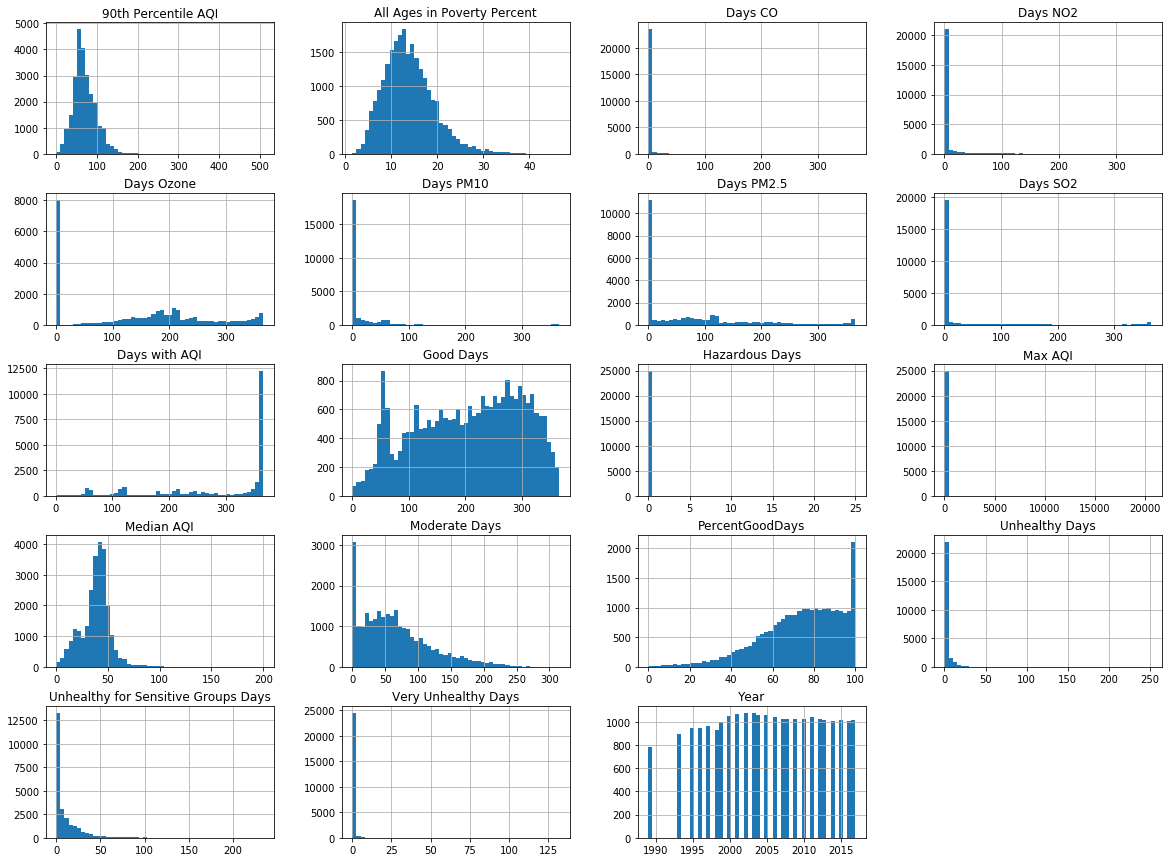

In [80]:
# suppress printed output
_ = combined_df.hist(bins=50, figsize=(20,15))

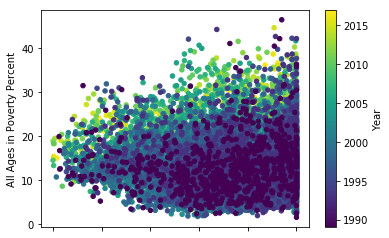

In [86]:
ax2 = combined_df.plot.scatter(x='PercentGoodDays',\
                               y='All Ages in Poverty Percent',\
                               c='Year',\
                               colormap='viridis')

In [ ]:
ax2 = combined_df.plot.scatter(x='PercentGoodDays',\
                               y='All Ages in Poverty Percent',\
                               c='Year',\
                               colormap='viridis')

In [87]:
# compute the correlations for each year
combined_df.Year.unique()

array([2017, 2016, 2015, 2013, 2014, 2012, 2010, 2011, 2009, 2008, 2007,
       2006, 2005, 2004, 2003, 2002, 2001, 2000, 1999, 1998, 1997, 1996,
       1995, 1993, 1989], dtype=int64)

In [139]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import rankdata
from scipy.stats import kendalltau

def compute_correlations_by_year(df):
    years = df.Year.unique()
    
    for year in years:
        df_year = df[df.Year == year]
        df_clean = df_year[['PercentGoodDays', 'All Ages in Poverty Percent']].dropna()
        n = df_clean.shape[0]
        rval, pval = pearsonr(df_clean['PercentGoodDays'], df_clean['All Ages in Poverty Percent'])
        print(f"Year: {year}, nobs: {n}, Pearson's r: {rval:.2f}, p-value: {pval:.2f}")
        rval, pval = spearmanr(df_clean['PercentGoodDays'], df_clean['All Ages in Poverty Percent'])
        print(f"Year: {year}, nobs: {n}, Spearman's r: {rval:.2f}, p-value: {pval:.2f}")
        x = rankdata(df_clean['PercentGoodDays'])
        y = rankdata(df_clean['All Ages in Poverty Percent'])
        rval, pval = kendalltau(x, y)
        print(f"Year: {year}, nobs: {n}, Kendall's tau: {rval:.2f}, p-value: {pval:.2f}")

compute_correlations_by_year(combined_df)

Year: 2017, nobs: 1016, Pearson's r: -0.02, p-value: 0.56
Year: 2017, nobs: 1016, Spearman's r: 0.01, p-value: 0.77
Year: 2017, nobs: 1016, Kendall's tau: 0.00, p-value: 0.86
Year: 2016, nobs: 1011, Pearson's r: -0.02, p-value: 0.51
Year: 2016, nobs: 1011, Spearman's r: 0.03, p-value: 0.30
Year: 2016, nobs: 1011, Kendall's tau: 0.02, p-value: 0.32
Year: 2015, nobs: 1018, Pearson's r: -0.05, p-value: 0.13
Year: 2015, nobs: 1018, Spearman's r: -0.00, p-value: 0.99
Year: 2015, nobs: 1018, Kendall's tau: -0.00, p-value: 0.97
Year: 2013, nobs: 1015, Pearson's r: -0.03, p-value: 0.37
Year: 2013, nobs: 1015, Spearman's r: 0.01, p-value: 0.64
Year: 2013, nobs: 1015, Kendall's tau: 0.01, p-value: 0.65
Year: 2014, nobs: 1008, Pearson's r: -0.09, p-value: 0.01
Year: 2014, nobs: 1008, Spearman's r: -0.05, p-value: 0.12
Year: 2014, nobs: 1008, Kendall's tau: -0.03, p-value: 0.13
Year: 2012, nobs: 1024, Pearson's r: -0.00, p-value: 0.90
Year: 2012, nobs: 1024, Spearman's r: 0.02, p-value: 0.54
Year:

C:\Users\dadra\anaconda\Anaconda3\lib\site-packages\scipy\stats\stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
C:\Users\dadra\anaconda\Anaconda3\lib\site-packages\scipy\stats\stats.py:5256: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


0.032623760894273934 10.612478541320115 0.1164615235661291 0.0010875425362064772 0.009949077076014968


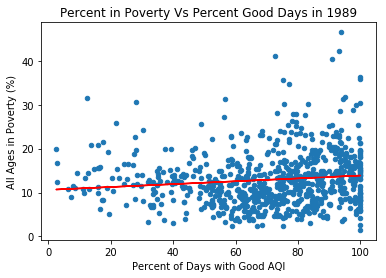

In [107]:
# plot subsets by year
from scipy.stats import linregress

def plot_by_year (df, year):
    df_year = df[df.Year == year]
    
    ax2 = df_year.plot.scatter(x='PercentGoodDays',\
                               y='All Ages in Poverty Percent')#\
                               #c='Median AQI',\
                               #colormap='viridis')

    ax2.set_xlabel("Percent of Days with Good AQI")
    ax2.set_ylabel("All Ages in Poverty (%)")
    ax2.set_title(f"Percent in Poverty Vs Percent Good Days in {year}")
    slope, intercept, r_value, p_value, std_err = linregress(df_year['PercentGoodDays'], df_year['All Ages in Poverty Percent'])
    print(slope, intercept, r_value, p_value, std_err)
    ax2.plot(df_year['PercentGoodDays'], intercept + slope * df_year['PercentGoodDays'], color = 'red')
    
plot_by_year(combined_df, 1989)

-0.03029854046973882 17.974133986209115 -0.0858676593816833 0.006374460593396481 0.011083733612657017


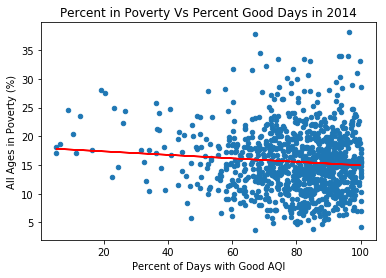

In [108]:
plot_by_year(combined_df, 2014)

-0.02544994565877975 14.59865948229373 -0.10392828674052607 0.0006896738892501547 0.0074771693014798035


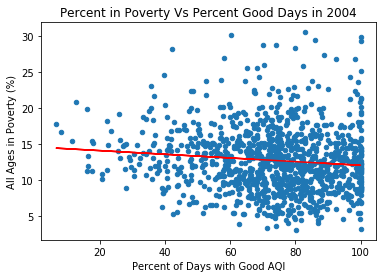

In [109]:
plot_by_year(combined_df, 2004)

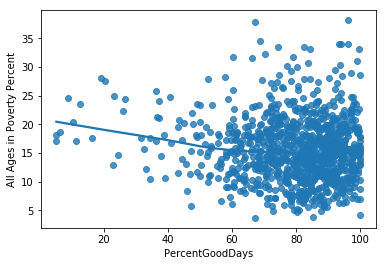

In [112]:
import seaborn

df_2014 = combined_df[combined_df.Year == 2014]
seaborn.regplot(df_2014['PercentGoodDays'], df_2014['All Ages in Poverty Percent'],lowess=True)


0.032623760894273934 10.612478541320115 0.1164615235661291 0.0010875425362064772 0.009949077076014968


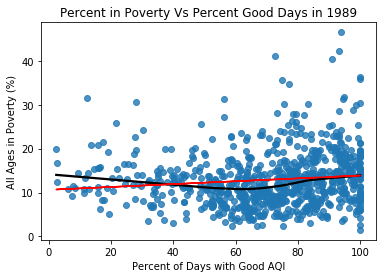

In [117]:
# plot subsets by year
from scipy.stats import linregress
import seaborn

def plot_by_year_seaborn (df, year):
    df_year = df[df.Year == year]
    
    ax2 = seaborn.regplot(df_year['PercentGoodDays'], df_year['All Ages in Poverty Percent'],lowess=True,\
                         line_kws={"color":"black"})
    #ax2 = df_year.plot.scatter(x='PercentGoodDays',\
    #                           y='All Ages in Poverty Percent')#\
                               #c='Median AQI',\
                               #colormap='viridis')

    ax2.set_xlabel("Percent of Days with Good AQI")
    ax2.set_ylabel("All Ages in Poverty (%)")
    ax2.set_title(f"Percent in Poverty Vs Percent Good Days in {year}")
    slope, intercept, r_value, p_value, std_err = linregress(df_year['PercentGoodDays'], df_year['All Ages in Poverty Percent'])
    print(slope, intercept, r_value, p_value, std_err)
    ax2.plot(df_year['PercentGoodDays'], intercept + slope * df_year['PercentGoodDays'], color = 'red')
    
plot_by_year_seaborn(combined_df, 1989)

-0.006462045648242465 14.330227651297388 -0.01819989981090463 0.5622847608626673 0.011148337499486245


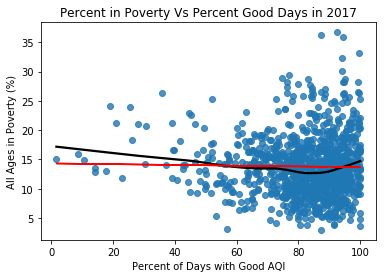

In [119]:
plot_by_year_seaborn(combined_df, 2017)

-0.007685725484950823 14.976854639978987 -0.02082992725489195 0.5082497209971215 0.01161334410812905


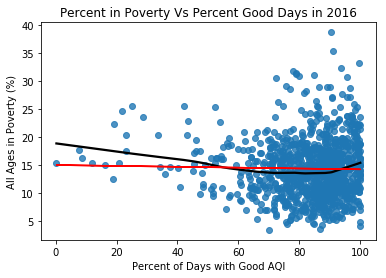

In [120]:
plot_by_year_seaborn(combined_df, 2016)

-0.03029854046973882 17.974133986209115 -0.0858676593816833 0.006374460593396481 0.011083733612657017


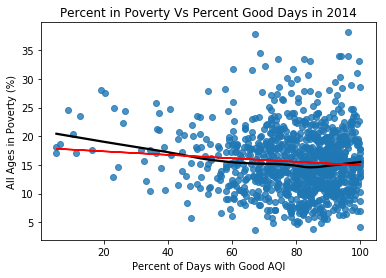

In [137]:
plot_by_year_seaborn(combined_df, 2014)

In [136]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy.builtins import *

model = smf.ols(formula = 'Q("All Ages in Poverty Percent") ~ PercentGoodDays + np.power(PercentGoodDays, 2)', data = df_2014).fit()
print(model.summary())

                                   OLS Regression Results                                   
Dep. Variable:     Q("All Ages in Poverty Percent")   R-squared:                       0.016
Model:                                          OLS   Adj. R-squared:                  0.014
Method:                               Least Squares   F-statistic:                     7.994
Date:                              Fri, 12 Apr 2019   Prob (F-statistic):           0.000359
Time:                                      15:29:04   Log-Likelihood:                -3140.5
No. Observations:                              1008   AIC:                             6287.
Df Residuals:                                  1005   BIC:                             6302.
Df Model:                                         2                                         
Covariance Type:                          nonrobust                                         
                                   coef    std err          t      P>|

In [138]:
model = smf.ols(formula = 'Q("All Ages in Poverty Percent") ~ PercentGoodDays + np.power(PercentGoodDays, 2)', data = combined_df).fit()
print(model.summary())

                                   OLS Regression Results                                   
Dep. Variable:     Q("All Ages in Poverty Percent")   R-squared:                       0.010
Model:                                          OLS   Adj. R-squared:                  0.010
Method:                               Least Squares   F-statistic:                     126.7
Date:                              Fri, 12 Apr 2019   Prob (F-statistic):           1.91e-55
Time:                                      15:30:13   Log-Likelihood:                -75532.
No. Observations:                             24196   AIC:                         1.511e+05
Df Residuals:                                 24193   BIC:                         1.511e+05
Df Model:                                         2                                         
Covariance Type:                          nonrobust                                         
                                   coef    std err          t      P>|

C:\Users\dadra\anaconda\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


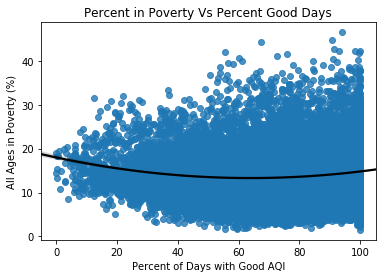

In [141]:
def plot_all_years_seaborn (df):
    
    ax2 = seaborn.regplot(df['PercentGoodDays'], df['All Ages in Poverty Percent'],\
                          order=2,\
                         line_kws={"color":"black"})

    ax2.set_xlabel("Percent of Days with Good AQI")
    ax2.set_ylabel("All Ages in Poverty (%)")
    ax2.set_title(f"Percent in Poverty Vs Percent Good Days")
    
plot_all_years_seaborn(combined_df)

In [142]:
# There is an approximate quadratic relationship between Percent of Days with Good AQI and All Ages in Poverty Percent.
# We see that as the Perrcent of Days with Good AQI increases, All Ages in Poverty Percent at first decreases but then increases again slightly


In [144]:
df_1989 = combined_df[combined_df.Year == 1989]

In [145]:
df_1989.shape

(784, 23)

In [146]:
df_1989.head()

,Name,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,...,Days NO2,Days Ozone,Days SO2,Days PM2.5,Days PM10,All Ages SAIPE Poverty Universe,All Ages in Poverty Count,All Ages in Poverty Percent,Median Household Income in Dollars,PercentGoodDays
24362,Autauga (AL),1989,63,54,9,0,0,0,0,100,...,0,63,0,0,0,NaN,"4,956",14.3,"$26,898",85.714286
24363,Colbert (AL),1989,359,263,53,33,10,0,0,200,...,0,0,359,0,0,NaN,"7,732",14.8,"$21,964",73.259053
24364,Etowah (AL),1989,57,54,3,0,0,0,0,54,...,0,0,0,0,57,NaN,"14,874",14.9,"$22,255",94.736842
24365,Houston (AL),1989,39,39,0,0,0,0,0,50,...,0,0,0,0,39,NaN,"12,822",15.7,"$24,816",100.000000
24366,Jackson (AL),1989,362,268,74,19,1,0,0,193,...,0,0,362,0,0,NaN,"7,301",15.1,"$23,015",74.033149


In [147]:
model = smf.ols(formula = 'Q("All Ages in Poverty Percent") ~ PercentGoodDays + np.power(PercentGoodDays, 2)', data = df_1989).fit()
print(model.summary())

                                   OLS Regression Results                                   
Dep. Variable:     Q("All Ages in Poverty Percent")   R-squared:                       0.044
Model:                                          OLS   Adj. R-squared:                  0.042
Method:                               Least Squares   F-statistic:                     18.12
Date:                              Fri, 12 Apr 2019   Prob (F-statistic):           2.03e-08
Time:                                      15:43:30   Log-Likelihood:                -2524.3
No. Observations:                               784   AIC:                             5055.
Df Residuals:                                   781   BIC:                             5069.
Df Model:                                         2                                         
Covariance Type:                          nonrobust                                         
                                   coef    std err          t      P>|

In [149]:
# What are the highest poverty percentages
df_1989[df_1989['All Ages in Poverty Percent'] >= 30]

,Name,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,...,Days NO2,Days Ozone,Days SO2,Days PM2.5,Days PM10,All Ages SAIPE Poverty Universe,All Ages in Poverty Count,All Ages in Poverty Percent,Median Household Income in Dollars,PercentGoodDays
24377,Apache (AZ),1989,340,247,87,6,0,0,0,150,...,1,318,21,0,0,NaN,"25,427",41.1,"$17,446",72.647059
24399,Phillips (AR),1989,33,31,2,0,0,0,0,54,...,0,0,0,0,33,NaN,"13,442",46.5,"$13,638",93.939394
24619,Bell (KY),1989,61,47,14,0,0,0,0,68,...,0,0,0,0,61,NaN,"10,948",34.8,"$15,516",77.049180
24632,Lawrence (KY),1989,55,52,3,0,0,0,0,62,...,0,0,0,0,55,NaN,"4,418",31.4,"$16,485",94.545455
24651,Orleans (LA),1989,365,274,89,1,1,0,0,182,...,192,123,0,0,21,NaN,"174,069",35.6,"$18,667",75.068493
24731,Adams (MS),1989,269,224,43,1,1,0,0,192,...,0,269,0,0,0,NaN,"10,702",30.2,"$16,634",83.271375
24753,St. Louis City (MO),1989,365,103,186,69,7,0,0,169,...,54,47,255,0,1,NaN,"120,402",30.6,"$18,335",28.219178
24817,Luna (NM),1989,23,23,0,0,0,0,0,46,...,0,0,0,0,23,NaN,"5,563",30.5,"$13,591",100.000000
24818,McKinley (NM),1989,3,3,0,0,0,0,0,48,...,0,0,0,0,3,NaN,"21,927",35.9,"$15,879",100.000000
24982,Jackson (SD),1989,336,319,17,0,0,0,0,93,...,0,328,0,8,0,NaN,894,31.7,"$19,411",94.940476


In [160]:
def convert_median_income (df):
    new_column = []
    for index, row in df.iterrows():
        income = df.loc[index,'Median Household Income in Dollars']
        if type(income) == str:
            new_column.append(float(income.strip('$').replace(',', '')))
        else:
            new_column.append(income)
        
    return new_column

clean_income = convert_median_income(combined_df)

In [161]:
combined_df['MedianIncome'] = clean_income

In [162]:
combined_df.head()

,Name,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,...,Days Ozone,Days SO2,Days PM2.5,Days PM10,All Ages SAIPE Poverty Universe,All Ages in Poverty Count,All Ages in Poverty Percent,Median Household Income in Dollars,PercentGoodDays,MedianIncome
0,Baldwin (AL),2017,270,241,28,1,0,0,0,108,...,206,0,64,0,"209,922","21,199",10.1,"$56,607",89.259259,56607.0
1,Clay (AL),2017,118,104,14,0,0,0,0,66,...,0,0,118,0,"13,086","2,363",18.1,"$39,642",88.135593,39642.0
2,Colbert (AL),2017,283,265,18,0,0,0,0,63,...,218,0,65,0,"53,907","8,324",15.4,"$46,100",93.639576,46100.0
3,DeKalb (AL),2017,359,329,30,0,0,0,0,80,...,315,0,44,0,"70,728","13,785",19.5,"$39,906",91.643454,39906.0
4,Elmore (AL),2017,226,221,5,0,0,0,0,58,...,226,0,0,0,"76,290","9,151",12.0,"$59,652",97.787611,59652.0


In [166]:
combined_df.to_csv("cleaned_all.csv")

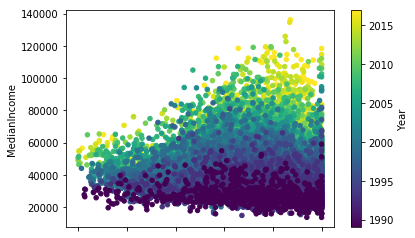

In [167]:
ax2 = combined_df.plot.scatter(x='PercentGoodDays',\
                               y='MedianIncome',\
                               c='Year',\
                               colormap='viridis')

In [168]:
# What year is the median income related to?